In [3]:
import gzip
import itertools
import string

import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import pylab as pl
import nltk


from collections import Counter
from sklearn import svm
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer


%matplotlib inline

In [4]:
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import wordnet
from sklearn import metrics
from collections import defaultdict

In [5]:
df=pd.read_csv('Dataset.csv')
df.head()

,Unnamed: 0,studentAnswer,referenceAnswer,ref_1,ref_2,accuracy
0,0,By letting it sit in a dish for a day.,"The water was evaporated, leaving the salt.",We evaporated the salt from the water because ...,I put some water in a dish and let the water e...,incorrect
1,1,Let the water evaporate and the salt is left b...,"The water was evaporated, leaving the salt.",We evaporated the salt from the water because ...,I put some water in a dish and let the water e...,correct
2,2,The water evaporated and left salt crystals.,"The water was evaporated, leaving the salt.",We evaporated the salt from the water because ...,I put some water in a dish and let the water e...,correct
3,3,I saw a pinkish grayish color that was blockin...,"The water was evaporated, leaving the salt.",We evaporated the salt from the water because ...,I put some water in a dish and let the water e...,incorrect
4,4,You have to slowly tip the vial for only the w...,"The water was evaporated, leaving the salt.",We evaporated the salt from the water because ...,I put some water in a dish and let the water e...,incorrect


In [6]:
text = df['studentAnswer']

In [7]:
text.count()

4925

In [8]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nada\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
stop_words = stopwords.words('english')

In [10]:
wordnet_lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'[a-z]+')

def preprocess(document):
    document = document.lower() # Convert to lowercase
    words = tokenizer.tokenize(document) # Tokenize
    words = [w for w in words if not w in stop_words] # Removing stopwords
    # Lemmatizing
    for pos in [wordnet.NOUN, wordnet.VERB, wordnet.ADJ, wordnet.ADV]:
        words = [wordnet_lemmatizer.lemmatize(x, pos) for x in words]
    return " ".join(words)



In [11]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Nada\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [26]:
df['studentAnswer'] = df['referenceAnswer'].apply(preprocess)

In [27]:
df.head()

,Unnamed: 0,studentAnswer,referenceAnswer,ref_1,ref_2,accuracy,processed_text
0,0,let sit dish day,let sit dish day,We evaporated the salt from the water because ...,I put some water in a dish and let the water e...,incorrect,let sit dish day
1,1,let water evaporate salt leave behind,let water evaporate salt leave behind,We evaporated the salt from the water because ...,I put some water in a dish and let the water e...,correct,let water evaporate salt leave behind
2,2,water evaporate leave salt crystal,water evaporate leave salt crystal,We evaporated the salt from the water because ...,I put some water in a dish and let the water e...,correct,water evaporate leave salt crystal
3,3,saw pinkish grayish color block water,saw pinkish grayish color block water,We evaporated the salt from the water because ...,I put some water in a dish and let the water e...,incorrect,saw pinkish grayish color block water
4,4,slowly tip vial water go,slowly tip vial water go,We evaporated the salt from the water because ...,I put some water in a dish and let the water e...,incorrect,slowly tip vial water go


In [28]:
studentAnswer = df["studentAnswer"]

In [30]:
x_train, x_test, y_train, y_test = train_test_split(df.studentAnswer, df.accuracy, random_state=0)

In [31]:
print("x_train shape: {}".format(x_train.shape), end='\n')
print("y_train shape: {}".format(y_train.shape), end='\n\n')
print("x_test shape: {}".format(x_test.shape), end='\n')
print("y_test shape: {}".format(y_test.shape), end='\n\n')

x_train shape: (3693,)
y_train shape: (3693,)

x_test shape: (1232,)
y_test shape: (1232,)



In [32]:
y_train

2864      correct
685       correct
2260      correct
3935      correct
221     incorrect
          ...    
4859    incorrect
3264    incorrect
1653    incorrect
2607    incorrect
2732      correct
Name: accuracy, Length: 3693, dtype: object

In [33]:
# Fitting and transforming the training data to a document-term matrix using TfidfVectorizer 
tfidf = TfidfVectorizer(min_df=5) #minimum document frequency of 5
X_train_tfidf = tfidf.fit_transform(x_train)
print("Number of features : %d \n" %len(tfidf.get_feature_names())) #1722
print("Show some feature names : \n", tfidf.get_feature_names()[::1000])

# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train_tfidf, y_train)

Number of features : 556 

Show some feature names : 
 ['able']


LogisticRegression()

In [34]:
feature_names = np.array(tfidf.get_feature_names())
sorted_coef_index = lr.coef_[0].argsort()
print('\nTop 10 features with the smallest coefficients :\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Top 10 features with the largest coefficients : \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))


Top 10 features with the smallest coefficients :
['iron' 'vibration' 'scratch' 'loop' 'vibrate' 'tape' 'people' 'vitamin'
 'celsius' 'heat']

Top 10 features with the largest coefficients : 
['sammy' 'protect' 'nathaniel' 'soil' 'stop' 'much' 'wood' 'keep' 'room'
 'slope']


In [35]:
def modelEvaluation(predictions):
    '''
    Print model evaluation to predicted result 
    '''
    print ("\nAccuracy on validation set: {:.4f}".format(accuracy_score(y_test, predictions)))
    #print("\nAUC score : {:.4f}".format(roc_auc_score(y_test, predictions)))
    print("\nClassification report : \n", metrics.classification_report(y_test, predictions))
    print("\nConfusion Matrix : \n", metrics.confusion_matrix(y_test, predictions))

In [36]:
predictions = lr.predict(tfidf.transform(x_test))
modelEvaluation(predictions)


Accuracy on validation set: 0.7078

Classification report : 
               precision    recall  f1-score   support

     correct       0.69      0.51      0.58       499
   incorrect       0.72      0.85      0.78       733

    accuracy                           0.71      1232
   macro avg       0.70      0.68      0.68      1232
weighted avg       0.71      0.71      0.70      1232


Confusion Matrix : 
 [[252 247]
 [113 620]]


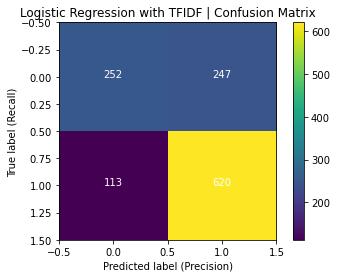

In [37]:

cfm = confusion_matrix(y_test, predictions)
plt.imshow(cfm, interpolation='nearest')

for i, j in itertools.product(range(cfm.shape[0]), range(cfm.shape[1])):
    plt.text(j, i, cfm[i, j],
             horizontalalignment="center",
             color="white")

plt.ylabel('True label (Recall)')
plt.xlabel('Predicted label (Precision)')
plt.title('Logistic Regression with TFIDF | Confusion Matrix')
plt.colorbar();